<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/DL-SatelliteImagery/Satellite_Imagery_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
from PIL import Image 
import numpy as np 
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [2]:
minmaxscaler = MinMaxScaler()

In [3]:
#from tensorflow.keras.utils import to_categorical 

In [5]:
#image_dataset = np.load('./dataset/saved_images_masks_npy/images/imagesChunk3.npy')
#labels = np.load('./dataset/saved_images_masks_npy/masks/masksChunk3.npy')

image_dataset = np.load('./dataset/saved_images_masks_npy/low_exp/images/testimages.npy')
labels = np.load('./dataset/saved_images_masks_npy//low_exp/masks/testmasks.npy')


In [6]:
image_dataset = image_dataset[:10]
labels = labels[:10]

In [7]:
image_dataset.shape

(2, 10980, 10980)

In [12]:
patch_len_x = 256
patch_len_y = 256

image_splits = []
label_splits = []

for record in range(image_dataset.shape[0]):
  print("record start", record)
  for ind_i in range(int(image_dataset.shape[1]/patch_len_x)):
    for ind_j in range(int(image_dataset.shape[2]/patch_len_y)):
            selected_patch = image_dataset[record][(ind_i * patch_len_x):((ind_i + 1) * patch_len_x), (ind_j * patch_len_y):((ind_j + 1) * patch_len_y)]
            selected_mask = labels[record][(ind_i * patch_len_x):((ind_i + 1) * patch_len_x), (ind_j * patch_len_y):((ind_j + 1) * patch_len_y)]
            image_splits.append(selected_patch)
            label_splits.append(selected_mask)

image_splits = np.concatenate(image_splits, axis=0)
label_splits = np.concatenate(label_splits, axis=0)

print("record end", record)


record start 0
record start 1
record end 1


In [13]:
image_splits = image_splits.reshape(-1, patch_len_x, patch_len_y)
label_splits = label_splits.reshape(-1, patch_len_x, patch_len_y)

In [23]:
image_splits.shape

(945, 256, 256, 1)

In [15]:
label_splits.shape

(3528, 256, 256)

In [21]:
image_splits = image_splits[:945]
label_splits = label_splits[:945]

label_splits = label_splits.reshape(-1, patch_len_x, patch_len_y, 1)
image_splits = image_splits.reshape(-1, patch_len_x, patch_len_y, 1)

In [22]:
label_splits.shape

(945, 256, 256, 1)

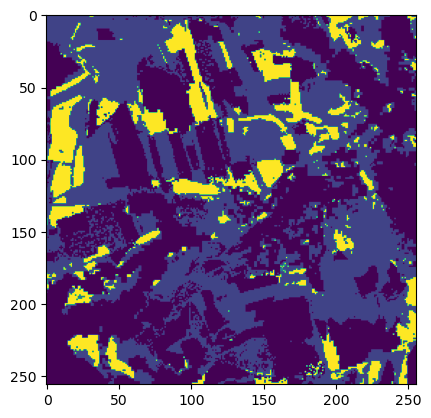

In [20]:
plt.imshow(label_splits[0])

In [24]:
np.unique(label_splits[0])

array([0, 1, 2, 3, 4, 5])

In [11]:
import torch.nn.functional as F

/home/luser/anaconda3/envs/stelar/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
import torch

In [13]:
label_splits = torch.tensor(label_splits[:5])

In [14]:
labels_cat = F.one_hot(label_splits[:5].long(), num_classes=10)


In [15]:
labels_cat[0,0,100]

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [16]:
image_splits = image_splits[:3]

In [17]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm


2023-06-26 09:07:01.812337: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 09:07:02.869985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [18]:
# load model

import keras.backend as K
import segmentation_models as sm

def dice_loss_plus_1focal_loss(y_true, y_pred):
    # Compute dice loss using the DiceLoss class from segmentation_models
    dice_loss = sm.losses.DiceLoss(class_weights=weights)(y_true, y_pred)

    # Compute focal loss using the CategoricalFocalLoss class from segmentation_models
    focal_loss = sm.losses.CategoricalFocalLoss()(y_true, y_pred)

    # Combine the dice loss and focal loss
    total_loss = dice_loss + (1 * focal_loss)

    return total_loss


In [19]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [20]:
import keras
from keras import models

# Register the custom loss function
keras.losses.dice_loss_plus_1focal_loss = dice_loss_plus_1focal_loss
keras.metrics.jaccard_coef = jaccard_coef
# Load the saved model
model = models.load_model('./saved_model/stelar_lai_segmentation.h5')


In [21]:
test = model.predict(image_splits)

1/1 [==============================] - 0s 429ms/step


In [22]:
test.shape

(3, 180, 180, 10)

In [23]:
prediction = (model.predict(image_splits))
print("prediction.shape", prediction.shape)

#convert the one-hot encoded prediction to a label image
prediction_act = np.argmax(prediction, axis=3)
print("prediction.shape", prediction.shape)



1/1 [==============================] - 0s 85ms/step
prediction.shape (3, 180, 180, 10)
prediction.shape (3, 180, 180, 10)


In [24]:
print(image_splits.shape)
print(prediction.shape)
print(prediction_act.shape)

(3, 180, 180)
(3, 180, 180, 10)
(3, 180, 180)


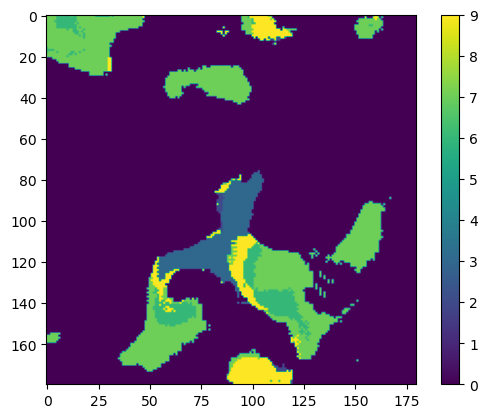

In [25]:
plt.imshow(prediction_act[0])
plt.colorbar()

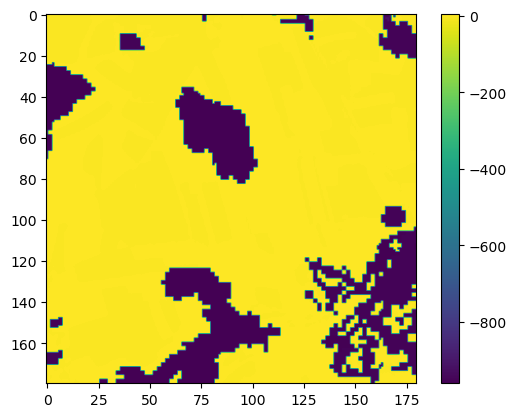

In [26]:
plt.imshow(image_splits[0])
plt.colorbar()

In [29]:
label_splits.shape

torch.Size([5, 180, 180])

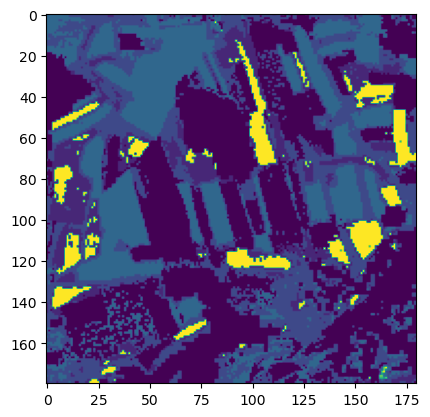

In [27]:
plt.imshow(label_splits[0])

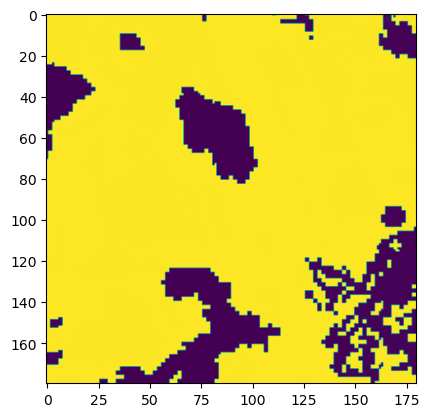

In [28]:
plt.imshow(image_splits[0,:,:])

In [ ]:
predicted_image.shape

In [ ]:
plt.imshow(predicted_image)